In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats

import sys
from pathlib import Path
d = Path().resolve().parent.parent
print(d)
print(Path().resolve())
sys.path.insert(0, str(d))

import util.utils as utils

from sklearn.linear_model import LogisticRegression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/
/Users/z002pck


ModuleNotFoundError: No module named 'util'

In [224]:
df = pd.read_csv("../data/sherbank-housing/train.csv")
df.shape

(30471, 292)

In [229]:
cols = ["id","life_sq","full_sq","build_year","num_room","timestamp","price_doc"]
nearby_features = ["office"]
prediction_cols = ["life_sq","build_year","num_room","transaction_year","log_life_sq"]

## Improving Features


### Drop Bad Rows From Training Set

In [230]:
#df[(pd.isnull(df["life_sq"]) | df["life_sq"]==0) & (pd.isnull(df["full_sq"]) | df["full_sq"]==0)].head(100)
df[df["id"]==17935]
df[df["id"]==6115]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
17932,17935,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,7,1,0,12,1,4425000


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
6112,6115,2013-02-22,6,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,7,1,0,12,1,5177040


In [231]:
df.drop(df.index[[6115,17932]], inplace=True)
# df.dropna(thresh=5)
# df[df["life_sq"]==0].head()
# df[df["life_sq"]==0].head()


### Process missing Values - Impute
- [Pandas link](http://pandas.pydata.org/pandas-docs/stable/missing_data.html)
- [Sklearn Imputer with pipeline](http://scikit-learn.org/stable/auto_examples/missing_values.html)
- [Checking nans SO](http://stackoverflow.com/questions/34779961/scikit-learn-error-in-fitting-model-input-contains-nan-infinity-or-a-value)
- [Replacing missing values fillna pandas](http://stackoverflow.com/questions/29177498/python-pandas-replace-nan-in-one-column-with-value-from-corresponding-row-of-sec)

In [232]:
def lowValueReplacer(df_features):
    df_features.loc[df_features.life_sq <= 10, 'life_sq'] = df_features.num_room * 10
    df_features.loc[df_features.life_sq <= 10, 'life_sq'] = df_features.full_sq.shift(0)
    return df_features
    
def zeroReplacerWithNan(df_features):
    df_features["life_sq"].replace(0,np.nan,inplace=True)
    return df_features

def imputer(df_features):
    df_features = zeroReplacerWithNan(df_features)
    df_features["life_sq"].fillna(df_features["full_sq"]-0.4*df_features["full_sq"],inplace=True)
    df_features = lowValueReplacer(df_features)
    df_features["num_room"].fillna(df_features["life_sq"]/14,inplace=True)
    df_features = df_features.fillna(df_features.median())
    return df_features

df = imputer(df)






# df_features.mean()

### Outlier Removal

- [Quantile based removal - SO](http://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles)
- [Remove all rows based on STD](http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe)

In [242]:
def oulierRemover(df_features):
    df_features[np.abs(df_features.life_sq-df_features.life_sq.mean())<=1000]
    return df_features

## Below outlier remover only works on training set as it removes extreme values of the predicted variable
def oulierRemover_train(df_features):
    return utils.filter_dataframe_percentile(df,{"price_doc":[0.001,0.99]})

df = oulierRemover(df)
df = oulierRemover_train(df)
# df_features[np.abs(df_features.life_sq-df_features.life_sq.mean())<=(6*df_features.life_sq.std())]

# df_features[np.abs(df_features.price_doc-df_features.price_doc.mean())<=(5*df_features.price_doc.std())]

# Removing all columns with outliers using z scores
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

### Adding new Features

In [243]:
def featureAdder(df_features):
    df_features['date_column'] = pd.to_datetime(df_features['timestamp'])
    df_features["transaction_year"] = df_features['date_column'].map(lambda x: x.year)
    df_features["log_life_sq"] = np.log(df_features["life_sq"])
    df_features["square_life_sq"] = df_features["life_sq"]**2
    df_features["square_root_life_sq"] = df_features["life_sq"]**0.5
    return df_features

df = featureAdder(df)

### Feature Transformations
- for polynomial regression see [Polynomial Regression SO](http://stackoverflow.com/questions/32660231/how-to-fit-a-polynomial-curve-to-data-using-scikit-learn)

In [185]:
# df_features["life_sq"] = np.log(df_features["life_sq"])
# predicted_col_name = price_doc here

def add_polynomial_and_log_feature(f_name,df):
    cnames=[f_name]
    log_col = "log_%s"%f_name
    df[f_name] = df[f_name]+1
    df[log_col] = np.log(df[f_name]+1)
    square_root_col = "square_root_%s"%f_name
    df[square_root_col] = df[f_name]**0.5
    square_col = "square_%s"%f_name
    df[square_col] = df[f_name]**2
    cube_col = "cube_%s"%f_name
    df[cube_col] = df[f_name]**3
    cnames += [log_col,square_col,cube_col,square_root_col]
    return cnames

def add_polynomial_log_features_prefix(f_name,df):
    colnames = df.columns[pd.Series(df.columns).str.startswith(f_name)]
    cnames = colnames.values.tolist()
    #cnames=[]
    for colname in colnames:
        cnames += add_polynomial_and_log_feature(colname,df)
    return cnames

def fit_nearby_feature(f_name,predicted_col_name,df):
    cnames = add_polynomial_log_features_prefix(f_name,df)
    regr = linear_model.LinearRegression(copy_X=True,n_jobs=2,normalize=True)
    X = df[cnames].values
    y = df[predicted_col_name].values
    regr.fit(X, y)
    return {"model":regr,"cols":cnames}

def add_nearby_feature(f_name,df,model,cnames):
    X = df[cnames].values
    df[f_name] = model.predict(X)
    df[f_name] = (df[f_name]-df[f_name].mean())/df[f_name].std()

nearby_models = {}

def train_transform(df):
    for f_name in nearby_features:
        f = fit_nearby_feature(f_name,"price_doc",df)
        nearby_models[f_name]= f
        add_nearby_feature(f_name,df,f["model"],f["cols"])
        return df
        
df = train_transform(df)
    
def test_transform(df_test):
    for f_name in nearby_features:
        cnames = add_polynomial_log_features_prefix(f_name,df_test)
        add_nearby_feature(f_name,df_test,nearby_models[f_name]["model"],nearby_models[f_name]["cols"])
    return df_test

for f_name in nearby_features:
    prediction_cols = list(set(prediction_cols + add_polynomial_log_features_prefix(f_name,df)))
prediction_cols.remove("log_office")
prediction_cols.remove("square_root_office")
prediction_cols.remove("square_office")
prediction_cols.remove("cube_office")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in log


In [186]:
df[prediction_cols+['price_doc']].head()

,office_count_500,cube_office_sqm_1500,office_km,cube_office_sqm_2000,office_sqm_1500,square_office_km,square_office_sqm_2000,square_root_office_sqm_5000,office_sqm_500,office_count_1500,...,log_office_count_1000,office_sqm_2000,square_office_count_3000,cube_office_count_3000,square_office_raion,log_office_sqm_1500,cube_office_km,square_office_sqm_5000,office_count_2000,price_doc
0,2,61892368791616,2.637189,6735849282326016,39556,6.954765,35666588736,898.547161,2,5,...,1.386294,188856,196,2744,9,10.585498,18.341028,651873767769,11,5850000
1,2,1089928616214528,2.688796,4534072495497728,102912,7.229626,27394222144,1640.264308,2,5,...,1.609438,165512,196,2744,4,11.541639,19.438991,7238612678089,6,6000000
2,2,8,3.543049,1006072249442408,2,12.553195,10040440804,1215.796858,2,2,...,1.098612,100202,100,1000,9,1.098612,44.476583,2184962898244,6,5700000
3,2,1331726132008,2.934273,1331726132008,11002,8.609961,121044004,494.133585,2,4,...,1.386294,11002,36,216,36,9.305923,25.263980,59618012224,4,13100000
4,17,1709649185936180480,2.077901,4292061397444299776,1195737,4.317672,2641054017424,2899.073300,293701,95,...,3.891820,1625132,94249,28934443,9025,13.994274,8.971696,70637738199876,151,16331452


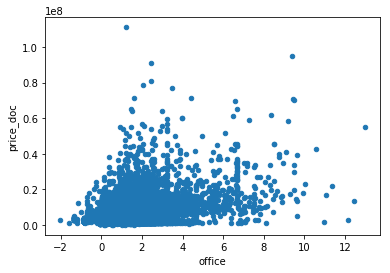

In [187]:
df.plot.scatter(x="office",y="price_doc")
plt.show();

## Model Build and Test

### Split train test

In [188]:
X = df[prediction_cols].values
y = df["price_doc"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

np.isnan(X).any()

False

In [189]:
def detect_nan_columns(df):
    columns = df.columns.values.tolist()
    for colname in columns:
        if(np.sum(np.isnan(df[colname]))>0):
            print(colname)
        
   
df[np.isnan(df["log_office"])][prediction_cols].head()
np.sum(np.isnan(df["life_sq"]))
detect_nan_columns(df[prediction_cols])

,office_count_500,cube_office_sqm_1500,office_km,cube_office_sqm_2000,office_sqm_1500,square_office_km,square_office_sqm_2000,square_root_office_sqm_5000,office_sqm_500,office_count_1500,...,square_office_count_2000,log_office_count_1000,office_sqm_2000,square_office_count_3000,cube_office_count_3000,square_office_raion,log_office_sqm_1500,cube_office_km,square_office_sqm_5000,office_count_2000
5085,2,8,19.112701,8,2,365.295357,4,1.414214,2,2,...,4,1.098612,2,4,8,4,1.098612,6981.781105,4,2
5333,2,8,19.182098,8,2,367.952871,4,1.414214,2,2,...,4,1.098612,2,4,8,4,1.098612,7058.107899,4,2
5675,2,8,19.112701,8,2,365.295357,4,1.414214,2,2,...,4,1.098612,2,4,8,4,1.098612,6981.781105,4,2
6152,2,8,18.721592,8,2,350.497990,4,1.414214,2,2,...,4,1.098612,2,4,8,4,1.098612,6561.880200,4,2
9528,2,8,19.185457,8,2,368.081779,4,1.414214,2,2,...,4,1.098612,2,4,8,4,1.098612,7061.817326,4,2


0

### Build model and generate predictions on split test 

In [190]:
# Create linear regression object
regr = linear_model.LinearRegression(copy_X=True,n_jobs=2,normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

def predict(X):
    y_pred = regr.predict(X)
    y_pred[y_pred < 10] = np.mean(y_pred)
    return y_pred

y_pred = predict(X_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=True)

In [191]:
eps = 1e-7
np.isnan(y_test).any()
np.any(np.absolute(y_pred) < eps)
np.log(y_test)

False

False

array([ 15.35022492,  16.15731636,  15.90737462, ...,  13.81551056,
        16.14606047,  15.77560534])

### Errors RMSE and RMSLE for train data

In [192]:
def findRMSLE(y_true,y_pred):
    return mean_squared_error(np.log(y_true), np.log(y_pred))

print('RMSLE: %.3f' % (findRMSLE(y_test, y_pred)))
print("RMSE: %.3f" % mean_squared_error(y_test, y_pred)**0.5)

RMSLE: 0.319
RMSE: 3407704.769


## Using Model on Test Set to generate prediction csv

In [200]:
df_test = pd.read_csv("../data/sherbank-housing/test.csv")
df_test.shape

(7662, 291)

### Extracting features and applying same transformations that were done on training data

In [194]:
df_test = imputer(df_test)
df_test = oulierRemover(df_test)
df_test = featureAdder(df_test)
df_test = test_transform(df_test)

In [195]:
df_test[prediction_cols].head()

,office_count_500,cube_office_sqm_1500,office_km,cube_office_sqm_2000,office_sqm_1500,square_office_km,square_office_sqm_2000,square_root_office_sqm_5000,office_sqm_500,office_count_1500,...,square_office_count_2000,log_office_count_1000,office_sqm_2000,square_office_count_3000,cube_office_count_3000,square_office_raion,log_office_sqm_1500,cube_office_km,square_office_sqm_5000,office_count_2000
0,1,1,5.923614,1,1,35.089204,1,193.780804,1,1,...,1,0.693147,1,1,1,25,0.693147,207.854904,1410077601,1
1,1,1,4.764819,1,1,22.703498,1,421.071253,1,1,...,1,0.693147,1,1,1,1,0.693147,108.178050,31435644601,1
2,1,39655309532301,2.223804,516583208041272,34101,4.945302,6438136644,654.133014,1,3,...,49,0.693147,80238,81,729,64,10.437111,10.997381,183089852100,7
3,1,1,9.102094,1,1,82.848112,1,1.000000,1,1,...,1,0.693147,1,1,1,1,0.693147,754.091283,1,1
4,1,1,5.338453,1,1,28.499083,1,342.492336,1,1,...,1,0.693147,1,1,1,1,0.693147,152.141024,13759524601,1


In [196]:
X_t = df_test[prediction_cols].values
y_t = predict(X_t)

### Generate Predictions

In [197]:
ids =np.array(df_test["id"]).astype(int)
my_solution = pd.DataFrame(y_t, ids, columns = ["price_doc"])
print(my_solution.shape)

(7662, 1)


### Save to CSV

In [198]:
my_solution.to_csv("../data/sherbank-housing/results/my_solution_one.csv", index_label = ["id"])